In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [14]:
# os.makedirs("celeba_gan", exist_ok=True)

# url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
# output = "celeba_gan/data.zip"
# gdown.download(url, output, quiet=True)

# with zipfile.ZipFile(output, "r") as zipobj:
#     zipobj.extractall("celeba_gan")

Found 202599 files.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99914217..0.97566056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9815545].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.905486..0.97263134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.93334293].
Clipping input data to the val

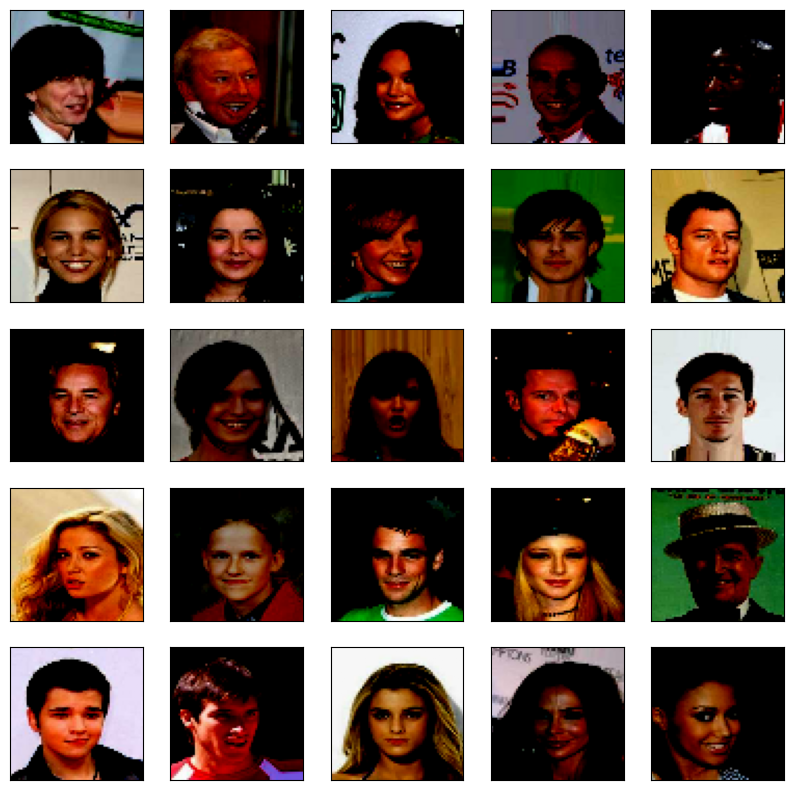

In [ ]:
# PyTorch dataset and dataloader
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])

# For CelebA, you'll need to use ImageFolder
from torchvision.datasets import ImageFolder
dataset = ImageFolder(root="celeba_gan", transform=transform)

# SPEED BOOST: Increase batch size and use pin_memory + prefetch
dataloader = DataLoader(
    dataset, 
    batch_size=128,  # Increased from 64 (2x faster per epoch)
    shuffle=True, 
    num_workers=4,   # Parallel data loading (adjust based on CPU cores)
    pin_memory=True, # Faster GPU transfer
    persistent_workers=True  # Keep workers alive between epochs
)

print(f"Dataset size: {len(dataset)}")

# Visualize samples
imgs, _ = next(iter(dataloader))
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = (imgs[i].permute(1, 2, 0).numpy() + 1) / 2.0  # [-1,1] -> [0,1]
    plt.imshow(img)
plt.show()

In [ ]:
latent_dim = 128

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.main = nn.Sequential(
            # Input: latent_dim -> 8x8x256
            nn.Linear(latent_dim, 8 * 8 * 256),
            nn.Unflatten(1, (256, 8, 8)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # 32x32 -> 64x64
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            # Output: 64x64x3
            nn.Conv2d(64, 3, 5, padding=2),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.main(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: 64x64x3
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            # 32x32
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # 16x16
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # 8x8
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            # 4x4 -> flatten -> 1
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

print("Generator parameters (M):", sum(p.numel() for p in generator.parameters())/1e6)
print("Discriminator parameters (M):", sum(p.numel() for p in discriminator.parameters())/1e6)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 3)      │         4,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,825,539 (14.59 MB)

 Trainable params: 3,824,131 (14.59 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
# Optimizers with better performance settings
g_optimizer = torch.optim.Adam(
    generator.parameters(), 
    lr=0.0002, 
    betas=(0.5, 0.999),
    fused=True  # SPEED BOOST: Fused optimizer (if supported)
)
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), 
    lr=0.0002, 
    betas=(0.5, 0.999),
    fused=True  # SPEED BOOST: Fused optimizer (if supported)
)

# Loss function
criterion = nn.BCELoss()

In [ ]:
@torch.no_grad()
def save_images(model, epoch, latent_dim, n=4):
    model.eval()
    noise = torch.randn(n * n, latent_dim, device=device)
    generated_images = model(noise)
    generated_images = (generated_images + 1) / 2.0  # [-1,1] -> [0,1]
    
    plt.figure(figsize=(8, 8))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = generated_images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
    plt.savefig("generated_image_epoch_%d.png" % epoch)
    plt.close()
    model.train()

In [ ]:
def train_dcgan(epochs, dataloader, latent_dim):
    generator.train()
    discriminator.train()
    
    # SPEED BOOST: Use automatic mixed precision (AMP)
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for real_images, _ in pbar:
            batch_size = real_images.size(0)
            real_images = real_images.to(device, non_blocking=True)  # Non-blocking transfer
            
            # Labels
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            d_optimizer.zero_grad(set_to_none=True)  # Slightly faster than zero_grad()
            
            with torch.cuda.amp.autocast():  # Mixed precision
                # Real images
                real_output = discriminator(real_images)
                d_loss_real = criterion(real_output, real_labels)
                
                # Fake images
                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_images = generator(noise)
                fake_output = discriminator(fake_images.detach())
                d_loss_fake = criterion(fake_output, fake_labels)
                
                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake
            
            scaler.scale(d_loss).backward()
            scaler.step(d_optimizer)
            scaler.update()
            
            # -----------------
            # Train Generator
            # -----------------
            g_optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast():  # Mixed precision
                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_images = generator(noise)
                fake_output = discriminator(fake_images)
                g_loss = criterion(fake_output, real_labels)
            
            scaler.scale(g_loss).backward()
            scaler.step(g_optimizer)
            scaler.update()
            
            pbar.set_postfix({"D_loss": d_loss.item(), "G_loss": g_loss.item()})
        
        # Save images every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            save_images(generator, epoch + 1, latent_dim)
        
        print(f"Epoch {epoch+1}/{epochs} - D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

In [ ]:
train_dcgan(epochs=50, dataloader=dataloader, latent_dim=latent_dim)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50


Epochs:   0%|          | 0/50 [00:09<?, ?it/s]/s]



KeyboardInterrupt: 

In [ ]:
# Optional: Generate and visualize samples without training
@torch.no_grad()
def generate_samples(num_samples=16):
    generator.eval()
    noise = torch.randn(num_samples, latent_dim, device=device)
    fake_images = generator(noise)
    fake_images = (fake_images + 1) / 2.0  # [-1,1] -> [0,1]
    
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = fake_images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
    plt.tight_layout()
    plt.show()
    generator.train()

# Uncomment to generate samples:
# generate_samples(16)